Status:  ✅  done

## Exercise 19

---

In this exercise we build on the knowledge from the previous exercise where we built a couple of small neural nets. Also in this exercise, we will be building a neural net from scratch, but this time also with the backpropagation which we skipped in the previous exercise for a more complex model. In the second, part, we will implement the exact same neural net using `PyTorch`. (Sorry, I do not like `keras`)

Therefore the **primary** learning goals are quite similar to the previous session:
- make sure you can explain:
    - what are the different layers in FFNN
    - what is an activation function 
    - what is an output function
    - how many parameters given architecture has
    - on **high level** how do we train FFNN (gradient descent, backpropagation)
- make sure you understand forward pass both using single input as well as $n$ inputs
- make sure you can explain how backpropagation works on simple example (make your own example that you would be comfortable presenting at the exam)
- get familiar with `PyTorch` api as we will use it for a more advanced task next exercise

Note that in the first exercise, the most challenging part is the backpropagation step therefore try to work on this in the group or refer to the solution below if you get stuck. I would also say that it is quite challenging part of the exercise therefore feel free to just copy-paste my code, however, make sure you can do the backpropagation on a small simple example as mentioned above and practiced in the previous exercise.

> Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_style("whitegrid");


import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import torch.optim as optim

### 🏷 From scratch implementation of given FFNN

---

> Intro to the problem (what are we going to implement)

The architecture of our `FFNN` includes:
- **2 input** neurons
- **4 hidden layer** neurons (activated by `sigmoid`)
- **1 output** neuron (activated by `sigmoid`)

As you can probably guess, our network task can be either regression or classification. For this problem, we will have our network to do `binary classification` as described below.

> Data

First, we will define a function which will create synthetic dataset which is designed in such a way that it will introduce an challenge for our network:

In [2]:
def syn(N):
    """
    Generate two circles - inner and outer
    where each circle represents samples from a particular class

    Attributes
    ----------
    N : int
        Number of samples to be returned
    
    Returns 
    -------
    data : 2D array
        Array with samples and their features.
    tar : 1D array
        Array with target classes (0 or 1)
    """

    np.random.seed(42) # for reproducibility

    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(2*N/3)
    
    # disk
    teta_d = np.random.uniform(0, 2*np.pi, N1)
    inner, outer = 3, 5
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N1))
    data[:N1,0],data[:N1,1] = r2*np.cos(teta_d), r2*np.sin(teta_d)
        
    #circle
    teta_c = np.random.uniform(0, 2*np.pi, N-N1)
    inner, outer = 0, 2
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N-N1))
    data[N1:,0],data[N1:,1] = r2*np.cos(teta_c), r2*np.sin(teta_c)
    
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    return data, tar.reshape(-1,1)

Next, we obtain the samples and create our `training` and `test` data:

In [3]:
N = 750

In [4]:
X_train, y_train = syn(N)
X_test, y_test = syn(int(N*.25))

Let's also visualize the training data so we know what we are dealing with:

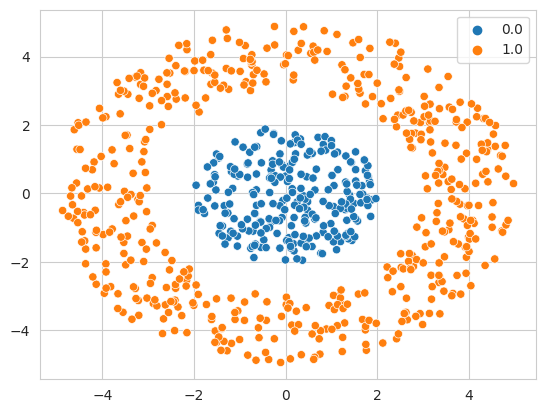

In [5]:
# Define plot
fig, ax = plt.subplots()

# Show the data
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train[:, 0], ax=ax);

> FFNN implementation - THEORY

Finally, we can move to the most important part of this section - **implementation**. I will start with the theory and then we will translate it to the code in the next subsection. I will number the steps in here as well as in the code for the easier orientation.

**[STEP 1] Model's Parameters and hyper-parameters initialization**
For the parameters between `input` and `hidden` layer:
- weights: $2 \times 4$ matrix
- biases: row vector with $4$ elements

And for the parameters between the `hidden` and `output` layer:
- weights: $4 \times 1$ matrix
- biases: row vector with $1$ element

**[STEP 2] Forward pass**
Forward pass essentially means that our model will take some input $X$ ($n \times 2$ matrix) and predict probabilities of class 1 for each sample as output ($n \times 1$ column vector). We can break the calculations into two steps:
1. From input to hidden:
-  $z_h = Xw_h + b_h$
- $a_h = \sigma(z_h)$
2. From hidden to output:
- $z_o = a_hw_o + b_o$
- $a_o = \sigma(z_o)$

Therefore, the whole prediction (forward step) can be written as follows:
$
h(x) = \sigma(\sigma(Xw_h + b_h)w_o + b_o)
$

**[STEP 3] Backpropagation**
Here we need to figure out the partial derivatives of our loss function (`cross entropy`) with respect to all the model's parameters. I suggest you look at slides 5 and 6 in the previous [lecture](https://learnit.itu.dk/pluginfile.php/336457/mod_resource/content/3/Slides_18_ANN_2.pdf). Here, you have a similar network, the only difference is that in our case the hidden layer has 4 neurons whereas on the slide, you only have 2 neurons. 

On the 6th slide, you can see essentially two columns - one describing how to derive the derivatives for the second layer and the other for the first layer. I tried to keep the notation same as in the slides.

**[STEP 4] Whole training procedure**
In this very last step, we combine the forward and backward pass into a single function which trains the model in the given number of epochs.

> FFNN implementation - CODE

We first implement the `sigmoid function` and its derivative:

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

Now, we can jump into translating the above outlined steps as follows:

In [7]:
class FFNN:

    def __init__(self, a=.01, epochs=100, debug=False):
        """[STEP 1]
        Here we define and initialize model's parameters.
        """
        # User defined attributes
        self.debug = debug
        self.a = a # (learning rate)
        self.epochs = epochs
        if self.debug: print("Model info\n" + "="*75)
        if self.debug: print(f">> Learning rate (a): {self.a}")
        if self.debug: print(f">> # of epochs: {self.epochs}")

        # Parameters of the normal distribution
        self.mean = 0
        self.std = .3
        if self.debug: print(f">> Parameters initialized from N({self.mean}, {self.std})")

        # From input to hidden layer
        self.wh = np.random.normal(self.mean, self.std, (2, 4))
        self.bh = np.random.normal(self.mean, self.std, (1, 4))
        if self.debug: print(f">> Input to hidden: weights ({self.wh.shape}), biases ({self.bh.shape})")

        # From hidden to output layer
        self.wo = np.random.normal(self.mean, self.std, (4, 1))
        self.bo = np.random.normal(self.mean, self.std, (1, 1))
        if self.debug: print(f">> Hidden to output: weights ({self.wo.shape}), biases ({self.bo.shape})\n")

        # Temporary variables for backpropagation
        self.zh = None
        self.ah = None
        self.zo = None
        self.ao = None

        # For reporting
        self.loss_history = []

    def predict_proba(self, X):
        """[STEP 2]
        Here we do the forward step.
        """
        # From input to hidden layer
        self.zh = X @ self.wh + self.bh
        self.ah = sigmoid(self.zh)

        # From hidden to output layer
        self.zo = self.ah @ self.wo + self.bo
        self.ao = sigmoid(self.zo)

        # Compute probability of the other class
        pclass1 = self.ao
        pclass0 = np.ones((X.shape[0], 1)) - pclass1
        
        # Create [n x 2] array where each row includes probs for each class
        prob = np.concatenate([pclass0, pclass1], axis=1)

        return prob
    
    def backpropagate(self, X, y):
        """[STEP 3]
        Find the gradient of each parameter
        and use it to update its actual value.

        Note:
        [1] How to read variable names: dL_dzo means partial derivative of the function L with respect
        to the variable zo.
        """
        # --- layer 2 --------------------------------------------
        # - intermediate calculations
        dL_dzo = self.ao - y
        dzo_dwo = self.ah

        # - gradients of the weights in the second layer
        dL_dwo = dzo_dwo.T @ dL_dzo
        dL_dbo = dL_dzo.sum(axis=0).reshape(1,-1)

        # --- layer 1 --------------------------------------------
        # - intermediate calculations
        dzo_dah = self.wo
        dL_dah = dL_dzo @ dzo_dah.T
        dah_dzh = sigmoid_der(self.zh)
        dL_dzh = dL_dah * dah_dzh
        dzh_dwh = X

        # - gradients of the weights in the first layer
        dL_dwh = dzh_dwh.T @ dL_dzh
        dL_dbh = dL_dzh.sum(axis=0).reshape(1,-1)

        # --- weights update --------------------------------------
        self.wh -= self.a * dL_dwh
        self.bh -= self.a * dL_dbh

        self.wo -= self.a * dL_dwo
        self.bo -= self.a * dL_dbo
    
    def fit(self, X, y):
        """[STEP 4]
        Put it all together.
        """
        self.loss_history = []
        for e in range(self.epochs):

            # Forward pass
            p = self.predict_proba(X)

            # Backward pass
            self.backpropagate(X, y)

            # Track progress
            self.loss_history.append(self.loss(y))
    
    def loss(self, y):
        """
        Implementation of loss function (cross entropy)
        """
        return np.sum(-y * np.log(self.ao))

    def d(self, p):
        """
        Implementation of the decision function.
        """
        return 1 if p > 0.5 else 0

    def predict(self, X):
        """
        Implementation of the predict function that outputs label for each
        sample.
        """
        return np.argmax(self.predict_proba(X), axis=1)

Let's try it out, first initializing the network with default attributes:

In [8]:
clf = FFNN(a=0.01, epochs=250, debug=True)

Model info
>> Learning rate (a): 0.01
>> # of epochs: 250
>> Parameters initialized from N(0, 0.3)
>> Input to hidden: weights ((2, 4)), biases ((1, 4))
>> Hidden to output: weights ((4, 1)), biases ((1, 1))



Second, train the network:

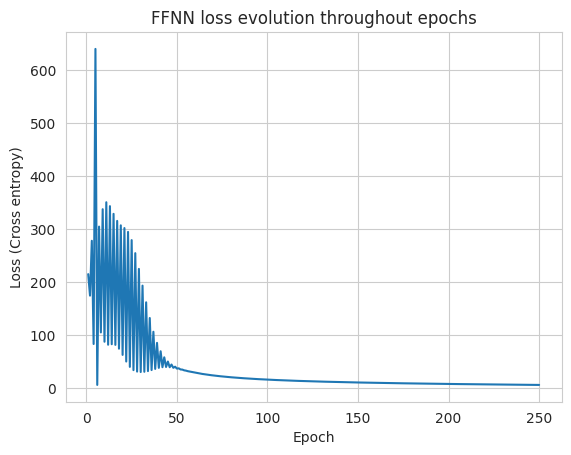

In [9]:
# Train it
clf.fit(X_train, y_train)

# Show the loss history
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(1, clf.epochs + 1, 1), y = clf.loss_history, ax=ax);
ax.set_xlabel("Epoch");
ax.set_ylabel("Loss (Cross entropy)");
ax.set_title("FFNN loss evolution throughout epochs");

Last, but not the least, let's plot the decision boundaries on the test data:

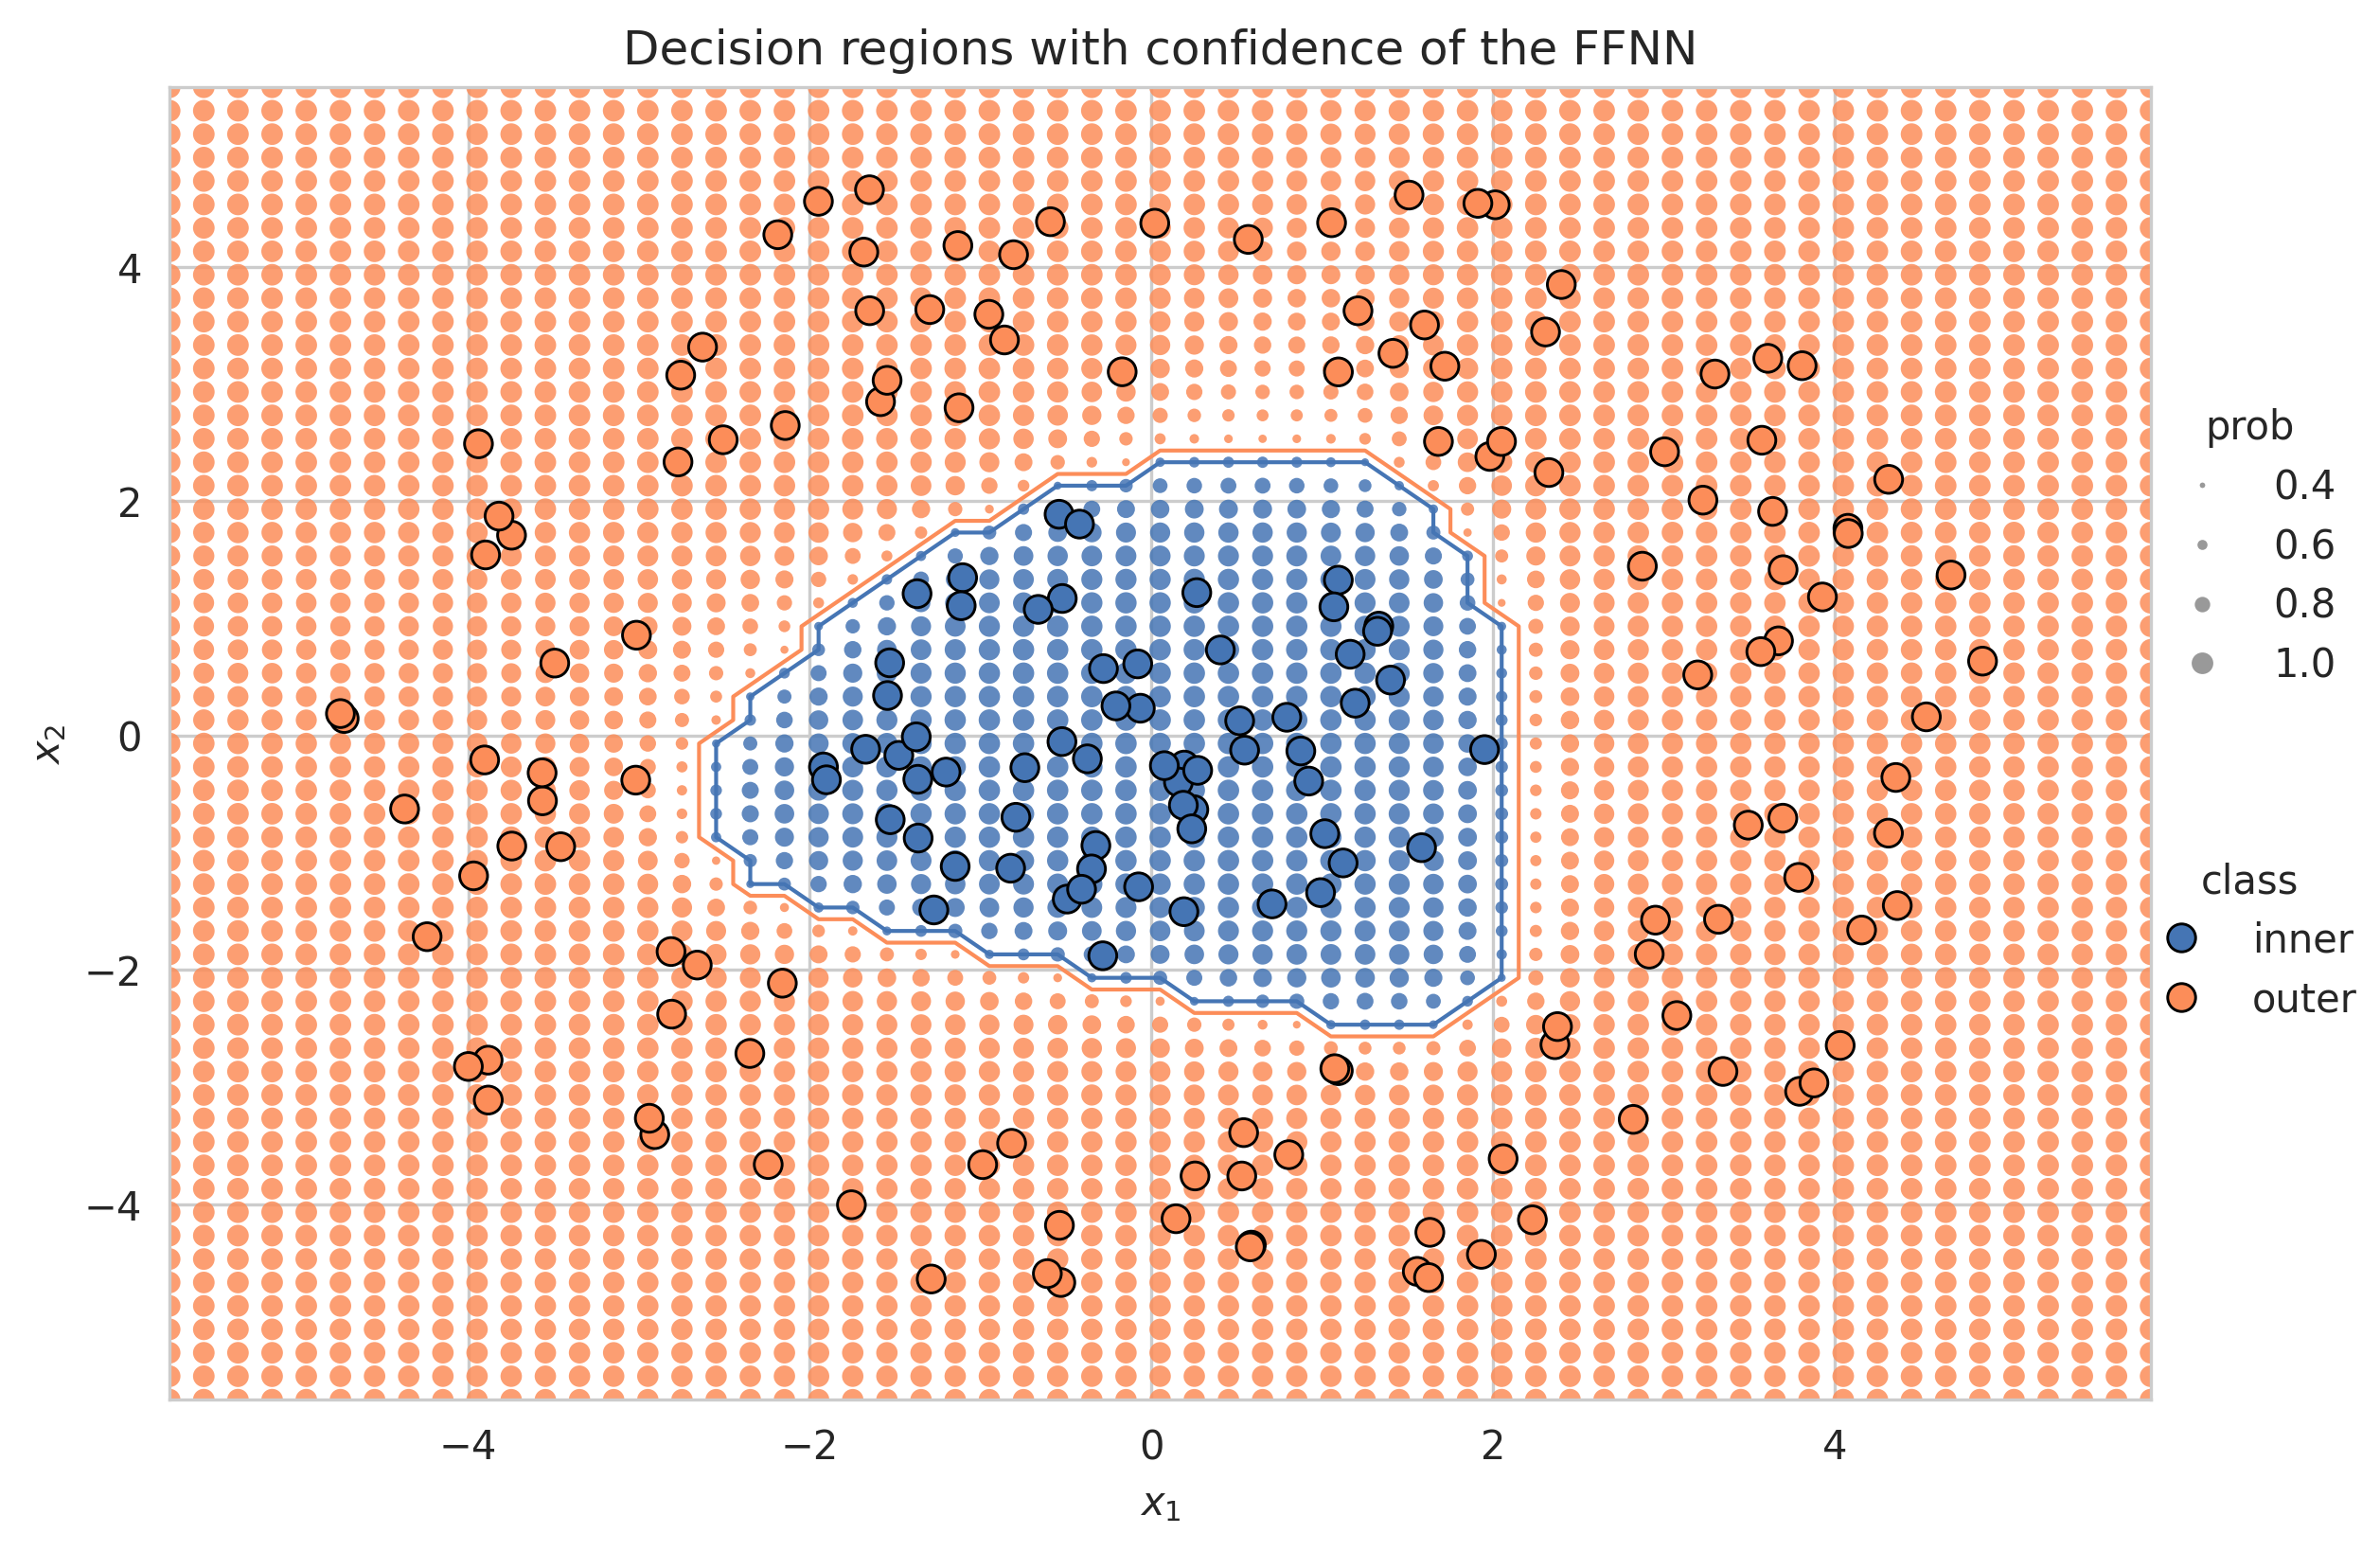

In [10]:
# --- Define plot and its properties
# - Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6), dpi=300)

# - Style and colors
sns.set_style("white")
orangeish = '#fc8d59'
blueish = '#4575b4'
colormap = np.array([blueish,orangeish])

# - Dots in the figure hyper-parameters
PROB_DOT_SCALE = 30 # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 50 # size of the true labels

# --- Define meshgrid
h = 0.2
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
x_range, y_range = np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)
xx0, xx1 = np.meshgrid(x_range, y_range)
xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))

# --- Define third and fourth dimensions: color and size of the dots
# - color of the dots based on the class
yy_hat = clf.predict(xx) 

# - size of the dot based on the probability
yy_prob = clf.predict_proba(xx)
yy_size = np.max(yy_prob, axis=1)

# --- Plotting
# - plot the test data
ax.scatter(X_test[:,0], X_test[:,1], c=colormap[y_test.flatten().astype(int)], s=TRUE_DOT_SIZE, zorder=3, 
           linewidths=0.7, edgecolor='k')

# - plot the dots
dotsize = PROB_DOT_SCALE*yy_size**PROB_DOT_SCALE_POWER
ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.85, s=dotsize, linewidths=0);

# - plot contour lines
zz = np.reshape(yy_hat,(xx0.shape[0],-1))
ax.contour(x_range, y_range, zz, 
           levels=1, linewidths=1,
           colors=[blueish,orangeish]);

# --- Labelling
# - class legend
legend_class = []
for cls, color in zip(['inner', 'outer'], [blueish, orangeish]):
    legend_class.append(Line2D([0], [0], marker='o', label=cls,ls='None',
                               markerfacecolor=color, markersize=np.sqrt(TRUE_DOT_SIZE), 
                               markeredgecolor='k', markeredgewidth=0.7))

legend1 = ax.legend(handles=legend_class, loc='center', 
                    bbox_to_anchor=(1.05, 0.35),
                    frameon=False, title='class')

# - prob legend
prob_values = [0.4, 0.6, 0.8, 1.0]
legend_prob = []
for prob in prob_values:
    legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                              markerfacecolor='grey', 
                              markersize=np.sqrt(PROB_DOT_SCALE*prob**PROB_DOT_SCALE_POWER), 
                              markeredgecolor='k', markeredgewidth=0))

legend2 = ax.legend(handles=legend_prob, loc='center', 
                    bbox_to_anchor=(1.05, 0.65),
                    frameon=False, title='prob', )

ax.add_artist(legend1) # add legend back after it disappears

# - axis
ax.set_xlabel("$x_1$");
ax.set_ylabel("$x_2$");
ax.set_title("Decision regions with confidence of the FFNN");

Works very nicely, as expected (based on the loss figure)!

> Section summary

Congratulations, you just know how to implement full fledged feed forward neural net. I am assuming that the most difficult part was the backpropagation, i.e., to determine all the partial derivaties and also vectorize the whole computation. I would not worry too much if you did not manage to get done the backpropagation step, but it is at essential to understand what it does. In addition, it is important to be able to write a forward step.

The major drawback of this approach is that it is tight to a specific architecture of the chosen neural net, therefore as we will see below when using `Pytorch`, we need a more general approach. If you are interested, I suggest you check out my generalized [implementation](https://github.com/ludekcizinsky/nano-learn/tree/main/nnlearn/network).

### 🏷 PyTorch implementation

---

> Intro to the problem

In this section, we will simply implement the exact same network as above, but using `PyTorch`. It should give you a better idea about how to train models in `PyTorch` which is a **deep learning** framework which makes it different from library like `sklearn` which rather focuses on more classical algorithms such as `SVM`.

> Loading data

First of all, `PyTorch` is built around the idea of `tensors`. Tensor is simply an $N$ dimensional array. Therofore, we first translate our data to tensors as follows:

In [11]:
# Training
X_train = tensor(X_train).float()
y_train = tensor(y_train).float()

# Test
X_test = tensor(X_test).float()

In [12]:
len(np.unique(y_train))

2

You can then use the `shape` API as you are used to from `numpy` to check the dimensions, e.g.:

In [13]:
X_train.shape

torch.Size([750, 2])

As expected, two dimensional tensor: $750$ training samples with $2$ features. Next, for efficient as well as convenient data access during training, `PyTorch` uses something called `dataloader` which can be obtained as follows: 

In [14]:
# We first need to define class with the following
# structure that essentially serves as an iterator
# over the given dataset
class ModelDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

# Next, we define the dataloader, note that
# you can also define the batch size and whether
# to shuffle the data after each epoch
training = ModelDataset(X_train,y_train)
trainloader = DataLoader(training, batch_size=1, shuffle=True)

> Training the model

Now, when we have prepared the data, we can advance to defining the model itself:

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return x

clf = Net()

Next, we define the optimizer and loss function:

In [16]:
criterion = nn.BCELoss()
optimizer = optim.SGD(clf.parameters(), lr=0.1)

Finally, we can train the model:

In [17]:
epochs = 50
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = clf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.8f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.68174771
[1,   200] loss: 0.64970012
[1,   300] loss: 0.68186019
[1,   400] loss: 0.63281876
[1,   500] loss: 0.59036606
[1,   600] loss: 0.63487108
[1,   700] loss: 0.60003462
[2,   100] loss: 0.67233534
[2,   200] loss: 0.56711776
[2,   300] loss: 0.62038410
[2,   400] loss: 0.63623408
[2,   500] loss: 0.65340770
[2,   600] loss: 0.61013728
[2,   700] loss: 0.61247801
[3,   100] loss: 0.56549776
[3,   200] loss: 0.54507562
[3,   300] loss: 0.56927069
[3,   400] loss: 0.50194945
[3,   500] loss: 0.52133626
[3,   600] loss: 0.54048717
[3,   700] loss: 0.44059261
[4,   100] loss: 0.43452067
[4,   200] loss: 0.37097096
[4,   300] loss: 0.34201923
[4,   400] loss: 0.34900839
[4,   500] loss: 0.32402463
[4,   600] loss: 0.29063920
[4,   700] loss: 0.25502371
[5,   100] loss: 0.22740355
[5,   200] loss: 0.19943448
[5,   300] loss: 0.19720232
[5,   400] loss: 0.19298213
[5,   500] loss: 0.18641903
[5,   600] loss: 0.15211248
[5,   700] loss: 0.15771874
[6,   100] loss: 0.1

Let's now check its performance on test data:

In [18]:
# Predict
yhat = (clf(X_test).detach().numpy().flatten() > .5).astype(int)

# Convert y b
acc = sum(yhat == y_test.flatten())/y_test.shape[0]
print("Test accuracy: {:.3f}".format(acc))

Test accuracy: 1.000


> Section summary

After this section, you should be able to train simple `PyTorch` model which includes:
- being able to load the data into a proper format needed by the library
- being able to choose suitable hyper-parameters (optimizer, learning rate, ...)
- being able to train the model
- being able to evaluate the model's performance (translating tensors back to numpy array and then computing whatever metric needed)

Note that this section focused on the bare minimum, but of course feel free to get more in depth with the `PyTorch` framework.

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a84d7837-a16c-41ab-afc2-7bc953f649ea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>